# <font color=indigo size=20> Dive into DICOM Datasets </font>

<font color=indigo><b> Work on progress... </b></font>  
<font color=indigo><b> Last updated: Jun.28.2019 </b></font>
  
---

This kernel is based on [Jesper's awesome kernel](https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data).   
And I used the external data made by [seesee](https://www.kaggle.com/seesee).  
  
Here I will do some EDA on train_rle and DICOM datasets.  

---

#### Helpful Passed Competitions:  
* [Latest Instance Segmentation Task (Airbus Ship Detection Challenge)](https://www.kaggle.com/c/airbus-ship-detection)  
    * Solutions  
    [4th](https://towardsdatascience.com/image-segmentation-kaggle-experience-9a41cb8924f0) : 
    U-Net, [watershed](https://en.wikipedia.org/wiki/Watershed_%28image_processing%29)  
    [6th](https://www.kaggle.com/c/airbus-ship-detection/discussion/71782#latest-558831) :
    empty / non-empty binary classifier, ResNetBased U-Net, ResNetBased MaskRCNN  
    [8th](https://www.kaggle.com/c/airbus-ship-detection/discussion/71601#latest-422002) :
    empty / non-empty binary classifier, U-Net, MaskRCNN  
    [9th](https://www.kaggle.com/c/airbus-ship-detection/discussion/71595#latest-457550) :
    empty / non-empty binary classifier, Densenet169Based U-Net  
    [10th](https://www.kaggle.com/c/airbus-ship-detection/discussion/71607#latest-423229) :
    MaskRCNN without ensemble  


* [Detection Task on Chest X-Ray Images (RSNA)](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge)
    * [External Data Thread](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/discussion/64345#latest-409834)
    * Solutions  
    [1st](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/discussion/70421#latest-496413), 
    [2nd](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/discussion/70427#latest-497399), 
    [3rd](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/discussion/70632#latest-440310), 
    [4th](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/discussion/71070#latest-525861), 
    [5th](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/discussion/79381#latest-465479), 
    [6th](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/discussion/70650#latest-417951), 
    [7th](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/discussion/79265#latest-464970), 
    [8th](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/discussion/79115#latest-464026), 
    [10th](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/discussion/71022#latest-419873)  


![](https://engineering.stanford.edu/sites/default/files/styles/full_width_banner_tall/public/xray.jpg?itok=kj2FlhrR)

---

# Load Packages

- We will use an excellent package **pydicom** which can treat DICOM datasets
- Also not forget to append a path to include **mask_functions.py**

In [1]:
import numpy as np
import pandas as pd
import os
import psutil
import glob

# https://pydicom.github.io/pydicom/stable/auto_examples/input_output/plot_read_dicom.html
import pydicom

#print(os.listdir("../input"))
#print(os.listdir("../input/siim-acr-pneumothorax-segmentation/"))

from matplotlib import cm
from matplotlib import pyplot as plt

import tensorflow as tf

from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import sys


from mask_functions import rle2mask
from multiprocessing.pool import Pool, ThreadPool
from joblib import Parallel, delayed

plt.style.use('ggplot')
pd.set_option("display.max_colwidth", 100)

Using TensorFlow backend.


# Run Length Encoded Data

In [2]:
tr_rle = pd.read_csv('../train-rle.csv')
print(tr_rle.shape)
tr_rle.head()

(11582, 2)


,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.1517875239.501137,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709,175349 7 1013 12 1009 17 1005 19 1003 20 1002 22 1001 22 1000 23 1000 23 1000 23 999 24 999 23 ...
3,1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,407576 2 1021 7 1015 10 1013 12 1011 14 1008 17 1006 19 1005 20 1003 21 1003 22 1001 23 1001 24...
4,1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1015 8 1014 9 1014 9 1013 10 1013 10 1012 11 1011 1...


As pointed out in discussion threads, some ImageIds have multiple rows in `train_rle.csv`. In that case, the patients seem to have multiple lung collapse.  
In test dataset, we must also predict multiple parts.  

> https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/discussion/97054#560819  
> Multiple instances of the same ImageId in any of the annotations files indicates the existence of multiple objects on the same image. Your submission should predict using multiple lines, a line representing each Pneumothorax object.

In [3]:
print('{} unique ImageId'.format(tr_rle.ImageId.nunique()))
tmp = tr_rle.groupby('ImageId').agg({'ImageId':['count']}).reset_index()
tmp.columns = ['ImageId', 'count']
id_multi = tmp.loc[tmp['count'] > 1, 'ImageId']
tr_rle[tr_rle['ImageId'].isin(id_multi)].head(10)

10675 unique ImageId


,ImageId,EncodedPixels
3,1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,407576 2 1021 7 1015 10 1013 12 1011 14 1008 17 1006 19 1005 20 1003 21 1003 22 1001 23 1001 24...
4,1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1015 8 1014 9 1014 9 1013 10 1013 10 1012 11 1011 1...
5,1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,162376 12 1007 18 1003 22 999 26 996 28 993 30 992 32 990 33 989 34 987 35 986 36 984 39 982 40...
6,1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,177708 1 1020 4 1018 5 1016 8 1013 11 1010 13 1008 16 1006 17 1004 20 1002 21 1001 22 999 25 99...
19,1.2.276.0.7230010.3.1.4.8323329.3604.1517875178.653360,218560 13 16 1 987 41 979 49 970 64 956 74 949 76 947 77 945 80 942 83 938 87 927 98 920 104 90...
20,1.2.276.0.7230010.3.1.4.8323329.3604.1517875178.653360,184910 8 1013 13 1009 15 1007 17 1006 17 1004 19 1003 21 1002 21 1001 23 1000 23 999 24 999 23 ...
23,1.2.276.0.7230010.3.1.4.8323329.32620.1517875161.509972,630937 2 1020 4 1019 6 1017 7 1017 7 1016 8 1015 9 1015 8 1015 9 1015 9 1014 10 1014 10 1013 10...
24,1.2.276.0.7230010.3.1.4.8323329.32620.1517875161.509972,274585 2 1020 4 1019 5 1018 6 1017 7 1016 8 1015 9 1014 10 1013 10 1013 11 1012 12 1012 12 1011...
25,1.2.276.0.7230010.3.1.4.8323329.32620.1517875161.509972,637076 1 1023 1 1022 2 1022 2 1021 3 1021 3 1020 4 1020 4 1019 5 1019 5 1019 5 1019 5 1018 6 10...
26,1.2.276.0.7230010.3.1.4.8323329.1187.1517875166.691986,223615 6 1008 23 994 35 986 42 979 45 975 49 972 51 970 53 967 56 963 60 958 66 955 68 954 70 9...


- In the case of segmenting small positive pixels, using stride 2 convolution can be sometimes crucial(making scores worse), using stride 1 convolution in the first layer of encoder would be better.
- So computing **Perimeters** and **Surfaces** would be interesting.  
Let's check those on examples with masks.

In [4]:
# Helper function
def calc_per_sur(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.sum(), lengths.sum()

In [5]:
tmp = tr_rle.loc[tr_rle['ImageId'].isin(id_multi), ' EncodedPixels'].apply(
    lambda x: calc_per_sur(x, 1024, 1024))
tr_rle['Perimeter'] = np.nan
tr_rle['Surface'] = np.nan
tr_rle['Surface_Ratio(%)'] = np.nan
tr_rle.loc[tr_rle['ImageId'].isin(id_multi), 'Perimeter'] = tmp.apply(lambda x: x[0])
tr_rle.loc[tr_rle['ImageId'].isin(id_multi), 'Surface'] = tmp.apply(lambda x: x[1])
tr_rle.loc[tr_rle['ImageId'].isin(id_multi), 'Surface_Ratio(%)'] = tmp.apply(lambda x: x[1] * 100 / 1024**2)
tr_rle.loc[:, 'Perimeter':'Surface_Ratio(%)'].describe()

,Perimeter,Surface,Surface_Ratio(%)
count,1.531000e+03,1531.000000,1531.000000
mean,2.408241e+06,9444.083605,0.900658
std,2.673271e+06,10483.416008,0.999776
min,2.040000e+04,80.000000,0.007629
25%,7.592625e+05,2977.500000,0.283957
50%,1.438965e+06,5643.000000,0.538158
75%,3.021240e+06,11848.000000,1.129913
max,2.243388e+07,87976.000000,8.390045


In [6]:
tr_rle[tr_rle['ImageId'].isin(id_multi)].head(10)

,ImageId,EncodedPixels,Perimeter,Surface,Surface_Ratio(%)
3,1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,407576 2 1021 7 1015 10 1013 12 1011 14 1008 17 1006 19 1005 20 1003 21 1003 22 1001 23 1001 24...,473280.0,1856.0,0.177002
4,1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1015 8 1014 9 1014 9 1013 10 1013 10 1012 11 1011 1...,1959420.0,7684.0,0.732803
5,1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,162376 12 1007 18 1003 22 999 26 996 28 993 30 992 32 990 33 989 34 987 35 986 36 984 39 982 40...,1550655.0,6081.0,0.579929
6,1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,177708 1 1020 4 1018 5 1016 8 1013 11 1010 13 1008 16 1006 17 1004 20 1002 21 1001 22 999 25 99...,1616445.0,6339.0,0.604534
19,1.2.276.0.7230010.3.1.4.8323329.3604.1517875178.653360,218560 13 16 1 987 41 979 49 970 64 956 74 949 76 947 77 945 80 942 83 938 87 927 98 920 104 90...,7382505.0,28951.0,2.760983
20,1.2.276.0.7230010.3.1.4.8323329.3604.1517875178.653360,184910 8 1013 13 1009 15 1007 17 1006 17 1004 19 1003 21 1002 21 1001 23 1000 23 999 24 999 23 ...,817785.0,3207.0,0.305843
23,1.2.276.0.7230010.3.1.4.8323329.32620.1517875161.509972,630937 2 1020 4 1019 6 1017 7 1017 7 1016 8 1015 9 1015 8 1015 9 1015 9 1014 10 1014 10 1013 10...,422535.0,1657.0,0.158024
24,1.2.276.0.7230010.3.1.4.8323329.32620.1517875161.509972,274585 2 1020 4 1019 5 1018 6 1017 7 1016 8 1015 9 1014 10 1013 10 1013 11 1012 12 1012 12 1011...,820590.0,3218.0,0.306892
25,1.2.276.0.7230010.3.1.4.8323329.32620.1517875161.509972,637076 1 1023 1 1022 2 1022 2 1021 3 1021 3 1020 4 1020 4 1019 5 1019 5 1019 5 1019 5 1018 6 10...,279225.0,1095.0,0.104427
26,1.2.276.0.7230010.3.1.4.8323329.1187.1517875166.691986,223615 6 1008 23 994 35 986 42 979 45 975 49 972 51 970 53 967 56 963 60 958 66 955 68 954 70 9...,5686755.0,22301.0,2.126789


* The Surfaces of masks is about 1 ~ 8 % of 1024 x 1024 pixcel images
* If we resize images, be careful of the number of stride

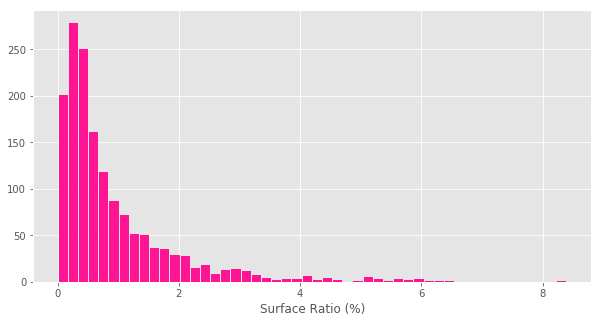

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
tr_rle['Surface_Ratio(%)'].hist(ax=ax, bins=50, color='deeppink', rwidth=0.9)
ax.set_xlabel('Surface Ratio (%)');

# sample_submission.csv

In [8]:
sub = pd.read_csv('../sample_submission.csv')
sub.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6067.1517875195.915618,-1
1,1.2.276.0.7230010.3.1.4.8323329.6214.1517875197.83920,-1
2,1.2.276.0.7230010.3.1.4.8323329.6177.1517875196.880733,-1
3,1.2.276.0.7230010.3.1.4.8323329.6655.1517875199.413686,-1
4,1.2.276.0.7230010.3.1.4.8323329.6359.1517875197.803699,-1


In [9]:
print('{} unique ImageId / {} rows'.format(sub.ImageId.nunique(), len(sub)))
tmp = sub.groupby('ImageId').agg({'ImageId':['count']}).reset_index()
tmp.columns = ['ImageId', 'count']
id_multi = tmp.loc[tmp['count'] > 1, 'ImageId']
print('{} ImageIds have multiple rows.'.format(len(id_multi)))
sub[sub['ImageId'].isin(id_multi)].head(10)

1372 unique ImageId / 1372 rows
0 ImageIds have multiple rows.


,ImageId,EncodedPixels


# DICOM Data

Dicom is a format that has metadata, as well as Pixeldata attached to it. Below I extract some basic info with an image. You will know about the gender and age of the patient, as well as info how the image is sampled and generated. Quite useful to programatically read. Here's the [Wikipedia](https://en.wikipedia.org/wiki/DICOM) article for it.  
  
In this section, we will use helper functions from the following kernel.  
https://www.kaggle.com/schlerp/getting-to-know-dicom-and-the-data/data

In [10]:
def show_dcm_info(fp, dataset):
    print("Filename.........:", fp.split('/')[-1])
    print("Storage type.....:", dataset.SOPClassUID)
    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.grid(False)
    plt.show()

Filename.........: 1.2.276.0.7230010.3.1.4.8323329.4125.1517875181.238913.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7
Patient's name......: 0f698f99-99a3-41e4-b801-f9fcfdbd9726, 
Patient id..........: 0f698f99-99a3-41e4-b801-f9fcfdbd9726
Patient's Age.......: 65
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 147804 bytes
Pixel spacing....: ['0.14300000000000002', '0.14300000000000002']


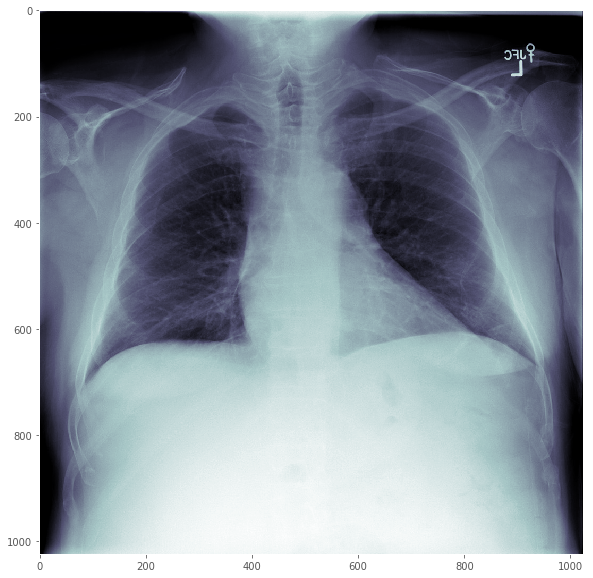

In [11]:
for fp in glob.glob('../dicom-images-train/*/*/*.dcm'):
    dataset = pydicom.dcmread(fp)
    show_dcm_info(fp, dataset)
    plot_pixel_array(dataset)
    break

DICOM datasets have more information in addition to above.  
Let's explore all attributes of a DICOM object and check whether other meaningful information exists or not.  

In [12]:
dicom_attr = ['AccessionNumber', 
              'BitsAllocated', 
              'BitsStored', 
              'BodyPartExamined', 
              'Columns', 
              'ConversionType', 
              'HighBit',
              'InstanceNumber',
              'LossyImageCompression',
              'LossyImageCompressionMethod',
              'Modality',
              'PatientAge',
              'PatientBirthDate',
              'PatientID',
              'PatientName',
              'PatientOrientation',
              'PatientSex',
              'PhotometricInterpretation',
#               'PixelData',
              'PixelRepresentation',
              'PixelSpacing',
              'ReferringPhysicianName',
              'Rows',
              'SOPClassUID',
              'SOPInstanceUID',
              'SamplesPerPixel',
              'SeriesDescription',
              'SeriesInstanceUID',
              'SeriesNumber',
              'SpecificCharacterSet',
              'StudyDate',
              'StudyID',
              'StudyInstanceUID',
              'StudyTime',
              'ViewPosition']

In [13]:
def create_features(fp):
    ret = []
    ret.append(fp.split('/')[-1][:-4])
    dataset = pydicom.dcmread(fp)
    for da in dicom_attr:
        ret.append(dataset.__getattr__(da))
    return np.array(ret).T

dicom_df = Parallel(n_jobs=psutil.cpu_count(), verbose=1)(
    (delayed(create_features)(fp) for fp in glob.glob('../dicom-images-train/*/*/*.dcm'))
)
dicom_df = pd.DataFrame(np.array(dicom_df), columns=['ImageId'] + dicom_attr)
dicom_df.head()

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 10712 out of 10712 | elapsed:    2.0s finished


,ImageId,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ConversionType,HighBit,InstanceNumber,LossyImageCompression,...,SamplesPerPixel,SeriesDescription,SeriesInstanceUID,SeriesNumber,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime,ViewPosition
0,1.2.276.0.7230010.3.1.4.8323329.4125.1517875181.238913,,8,8,CHEST,1024,WSD,7,1,01,...,1,view: PA,1.2.276.0.7230010.3.1.3.8323329.4125.1517875181.238911,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.4125.1517875181.238912,000000.00,PA
1,1.2.276.0.7230010.3.1.4.8323329.1469.1517875167.950672,,8,8,CHEST,1024,WSD,7,1,01,...,1,view: AP,1.2.276.0.7230010.3.1.3.8323329.1469.1517875167.950670,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.1469.1517875167.950671,000000.00,AP
2,1.2.276.0.7230010.3.1.4.8323329.2375.1517875172.428156,,8,8,CHEST,1024,WSD,7,1,01,...,1,view: PA,1.2.276.0.7230010.3.1.3.8323329.2375.1517875172.428154,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.2375.1517875172.428155,000000.00,PA
3,1.2.276.0.7230010.3.1.4.8323329.32095.1517875158.398013,,8,8,CHEST,1024,WSD,7,1,01,...,1,view: PA,1.2.276.0.7230010.3.1.3.8323329.32095.1517875158.398011,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.32095.1517875158.398012,000000.00,PA
4,1.2.276.0.7230010.3.1.4.8323329.32622.1517875161.528466,,8,8,CHEST,1024,WSD,7,1,01,...,1,view: AP,1.2.276.0.7230010.3.1.3.8323329.32622.1517875161.528464,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.32622.1517875161.528465,000000.00,AP


Let's check the number of unique values in each column.

In [14]:
dicom_df['PixelSpacing'] = dicom_df['PixelSpacing'].apply(lambda x: x[0])
dicom_df.nunique()

ImageId                        10712
AccessionNumber                    1
BitsAllocated                      1
BitsStored                         1
BodyPartExamined                   1
Columns                            1
ConversionType                     1
HighBit                            1
InstanceNumber                     1
LossyImageCompression              1
LossyImageCompressionMethod        1
Modality                           1
PatientAge                        93
PatientBirthDate                   1
PatientID                      10712
PatientName                    10712
PatientOrientation                 1
PatientSex                         2
PhotometricInterpretation          1
PixelRepresentation                1
PixelSpacing                      11
ReferringPhysicianName             1
Rows                               1
SOPClassUID                        1
SOPInstanceUID                 10712
SamplesPerPixel                    1
SeriesDescription                  2
S

There looks only 5 features to be useful.  
( Column `ReferringPhysicianName` is empty )

In [15]:
useful_col = ['ImageId',
              'PatientAge', 
              'PatientSex', 
#               'ReferringPhysicianName',
              'ViewPosition', 
              'PixelSpacing']
tr_rle = tr_rle.merge(dicom_df.loc[:, useful_col], how='left', on='ImageId')
tr_rle.loc[:, 'IsDisease'] = (tr_rle.loc[:, ' EncodedPixels'] != ' -1')
tr_rle.head()

,ImageId,EncodedPixels,Perimeter,Surface,Surface_Ratio(%),PatientAge,PatientSex,ViewPosition,PixelSpacing,IsDisease
0,1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090,-1,NaN,NaN,NaN,51,F,PA,0.194311,False
1,1.2.276.0.7230010.3.1.4.8323329.12515.1517875239.501137,-1,NaN,NaN,NaN,17,F,AP,0.168000,False
2,1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709,175349 7 1013 12 1009 17 1005 19 1003 20 1002 22 1001 22 1000 23 1000 23 1000 23 999 24 999 23 ...,NaN,NaN,NaN,69,F,PA,0.143000,True
3,1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,407576 2 1021 7 1015 10 1013 12 1011 14 1008 17 1006 19 1005 20 1003 21 1003 22 1001 23 1001 24...,473280.0,1856.0,0.177002,57,F,AP,0.168000,True
4,1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1015 8 1014 9 1014 9 1013 10 1013 10 1012 11 1011 1...,1959420.0,7684.0,0.732803,57,F,AP,0.168000,True


# Explore the Relationships between the Onset of Pneumothorax and Features.
## PatientAge

- There is an example which has **413** age. I guess he will be a wizard.

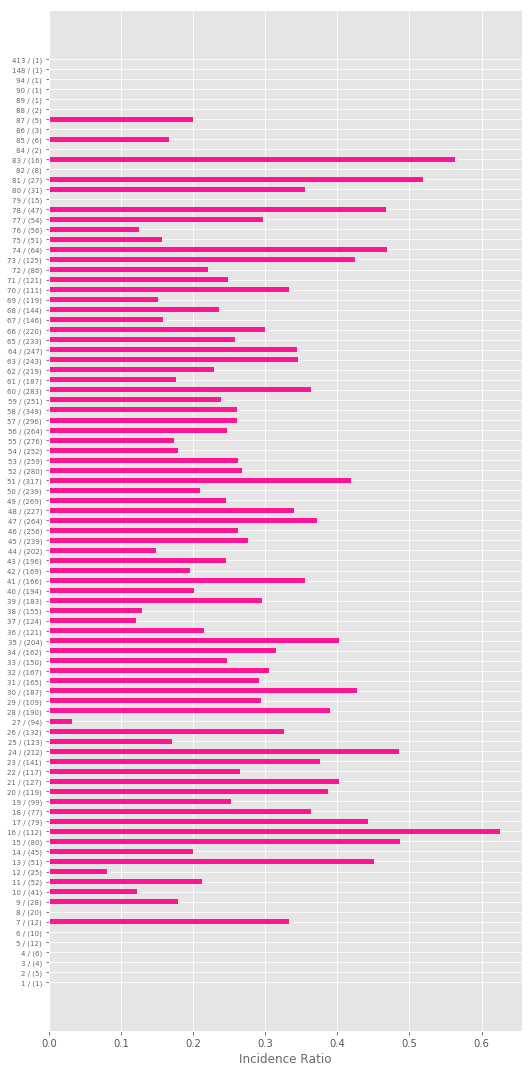

In [16]:
tmp = tr_rle.groupby('PatientAge').agg({
    'IsDisease':['count', 'sum']
}).reset_index()
tmp.columns = ['PatientAge', 'count', 'sum']
tmp['PatientAge'] = tmp['PatientAge'].astype('int')
tmp.sort_values(by='PatientAge', inplace=True)
tmp['Ratio'] = tmp['sum'] / tmp['count']

fig, ax = plt.subplots(figsize=(7.5, 15))
ax.barh(range(len(tmp)), tmp['Ratio'], 
        color='deeppink', align='center', height=0.5)
ax.set_yticks(range(len(tmp)))
ax.set_yticklabels(tmp['PatientAge'].astype('str') + ' / (' + tmp['count'].astype('str') + ')', 
                   fontsize=7, color='dimgray')
ax.set_xlabel('Incidence Ratio', color='dimgray')
fig.tight_layout();

## PatinetSex

- The annual age-adjusted incidence rate (AAIR) of PSP is thought to be three to six times as high in males as in females.  
  [wikipedia Pneumothorax](https://en.wikipedia.org/wiki/Pneumothorax)
- If the mechanisms of onset of Pneumothorax is different in each sex, building each model would be interesting.  

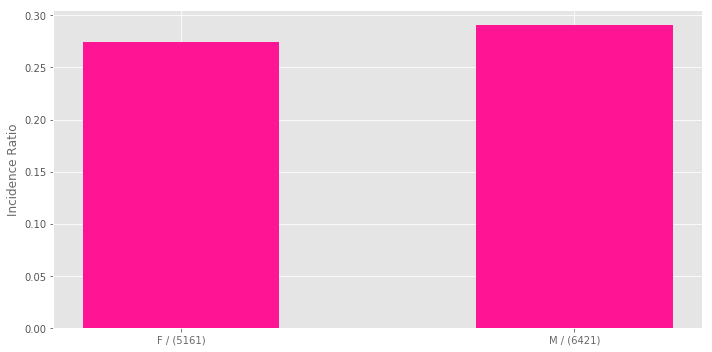

In [17]:
tmp = tr_rle.groupby('PatientSex').agg({
    'IsDisease':['count', 'sum']
}).reset_index()
tmp.columns = ['PatientSex', 'count', 'sum']
tmp['Ratio'] = tmp['sum'] / tmp['count']

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(range(len(tmp)), tmp['Ratio'], 
        color='deeppink', align='center', width=0.5)
ax.set_xticks(range(len(tmp)))
ax.set_xticklabels(tmp['PatientSex'].astype('str') + ' / (' + tmp['count'].astype('str') + ')', 
                   fontsize=10, color='dimgray')
ax.set_ylabel('Incidence Ratio', color='dimgray')
fig.tight_layout();

## ViewPosition

- I can't understand the difference of AP and PA in incidence ratio is meaningful or not.  
[What is the difference between an AP and a PA view of an X-ray?](https://www.quora.com/What-is-the-difference-between-an-AP-and-a-PA-view-of-an-X-ray)

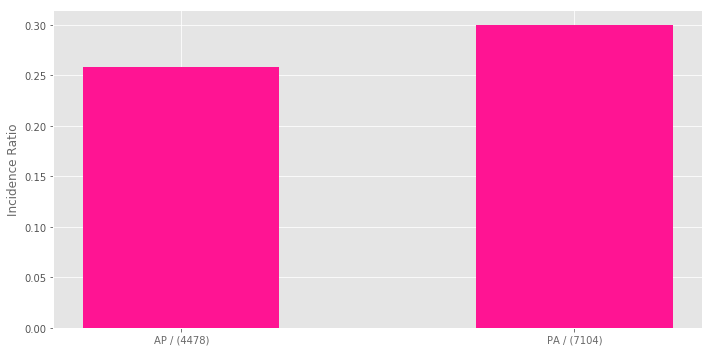

In [18]:
tmp = tr_rle.groupby('ViewPosition').agg({
    'IsDisease':['count', 'sum']
}).reset_index()
tmp.columns = ['ViewPosition', 'count', 'sum']
tmp['Ratio'] = tmp['sum'] / tmp['count']

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(range(len(tmp)), tmp['Ratio'], 
        color='deeppink', align='center', width=0.5)
ax.set_xticks(range(len(tmp)))
ax.set_xticklabels(tmp['ViewPosition'].astype('str') + ' / (' + tmp['count'].astype('str') + ')', 
                   fontsize=10, color='dimgray')
ax.set_ylabel('Incidence Ratio', color='dimgray')
fig.tight_layout();

## PixelSpacing

- There are 11 kinds of PixelSpacing.

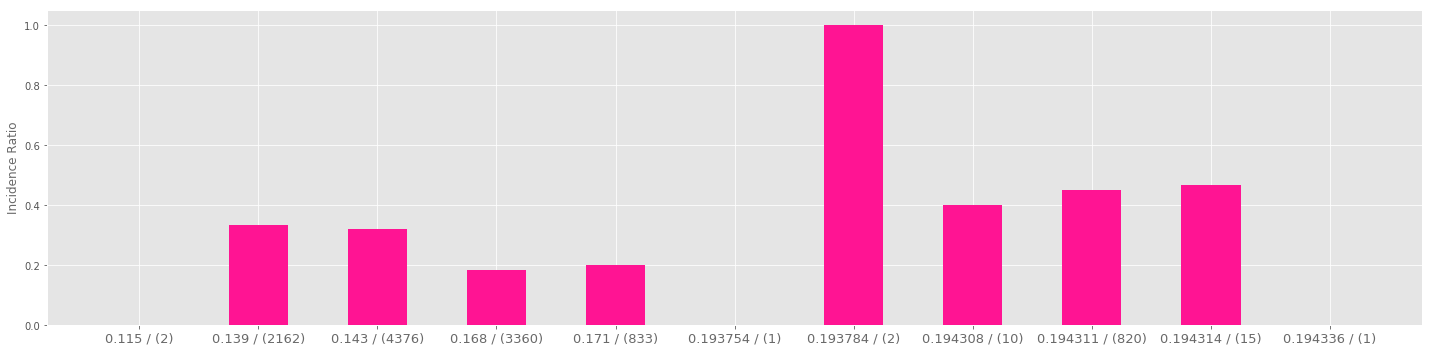

In [19]:
tr_rle['PixelSpacing'] = tr_rle['PixelSpacing'].round(6)
tmp = tr_rle.groupby('PixelSpacing').agg({
    'IsDisease':['count', 'sum']
}).reset_index()
tmp.columns = ['PixelSpacing', 'count', 'sum']
tmp['Ratio'] = tmp['sum'] / tmp['count']

fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(range(len(tmp)), tmp['Ratio'], 
        color='deeppink', align='center', width=0.5)
ax.set_xticks(range(len(tmp)))
ax.set_xticklabels(tmp['PixelSpacing'].astype('str') + ' / (' + tmp['count'].astype('str') + ')', 
                   fontsize=13, color='dimgray')
ax.set_ylabel('Incidence Ratio', color='dimgray')
fig.tight_layout();

# How do the masks look like?

First let's look at all the sample images. We can see different modes of collection. It becomes very evident, that we have to be careful about the top right marker on the image. The different L may mess with our data. Could it be usable leakage as it points to the hospital it was taken at? Yes, yes it could, but I'm *sure* Kaggle took care of this.

Then we'll look at 3 images and the masks that come with it. Personally, I can't really make out how to find the in the images. Play around with it, in some of the other images, it is definitely more visible.

## X-Ray Images without Mask

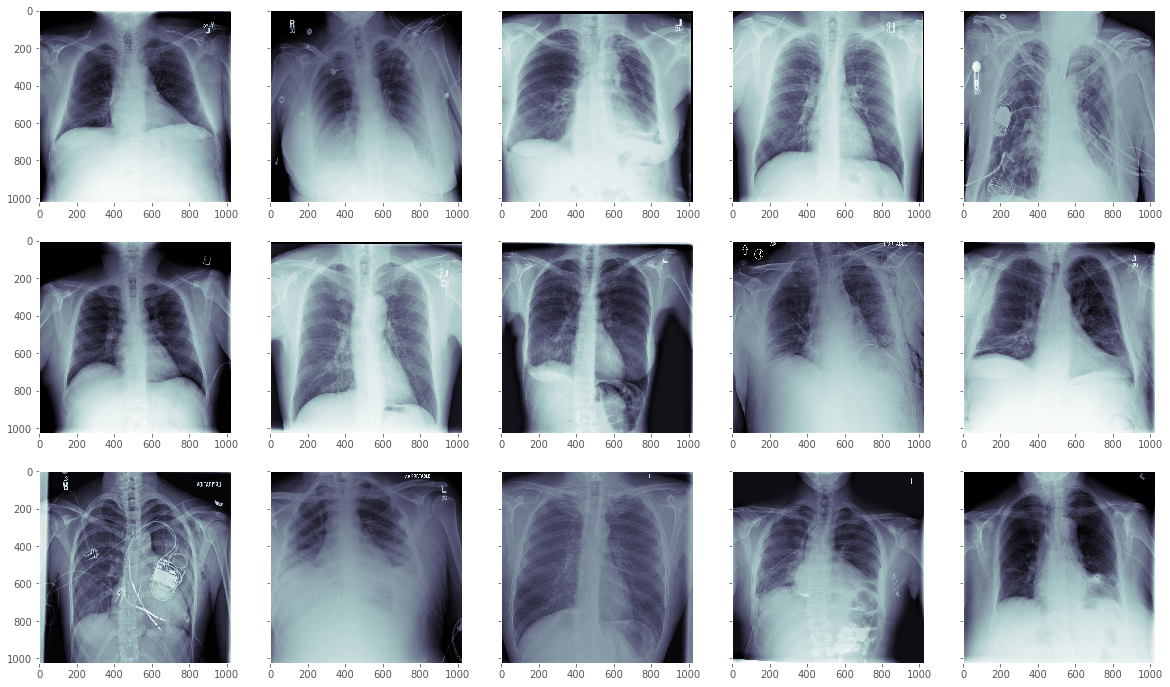

In [20]:
num_img = 5 * 3
fig, ax = plt.subplots(nrows=num_img // 5, ncols=5, sharey=True, figsize=(20, num_img // 5 * 4))
axes = ax.ravel()
for q, fp in enumerate(glob.glob('../dicom-images-train/*/*/*.dcm')[:num_img]):
    dataset = pydicom.dcmread(fp)
    axes[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)
    axes[q].grid(False)

## X-Ray Images with Masks

- Can you identify the diseases? I could not...

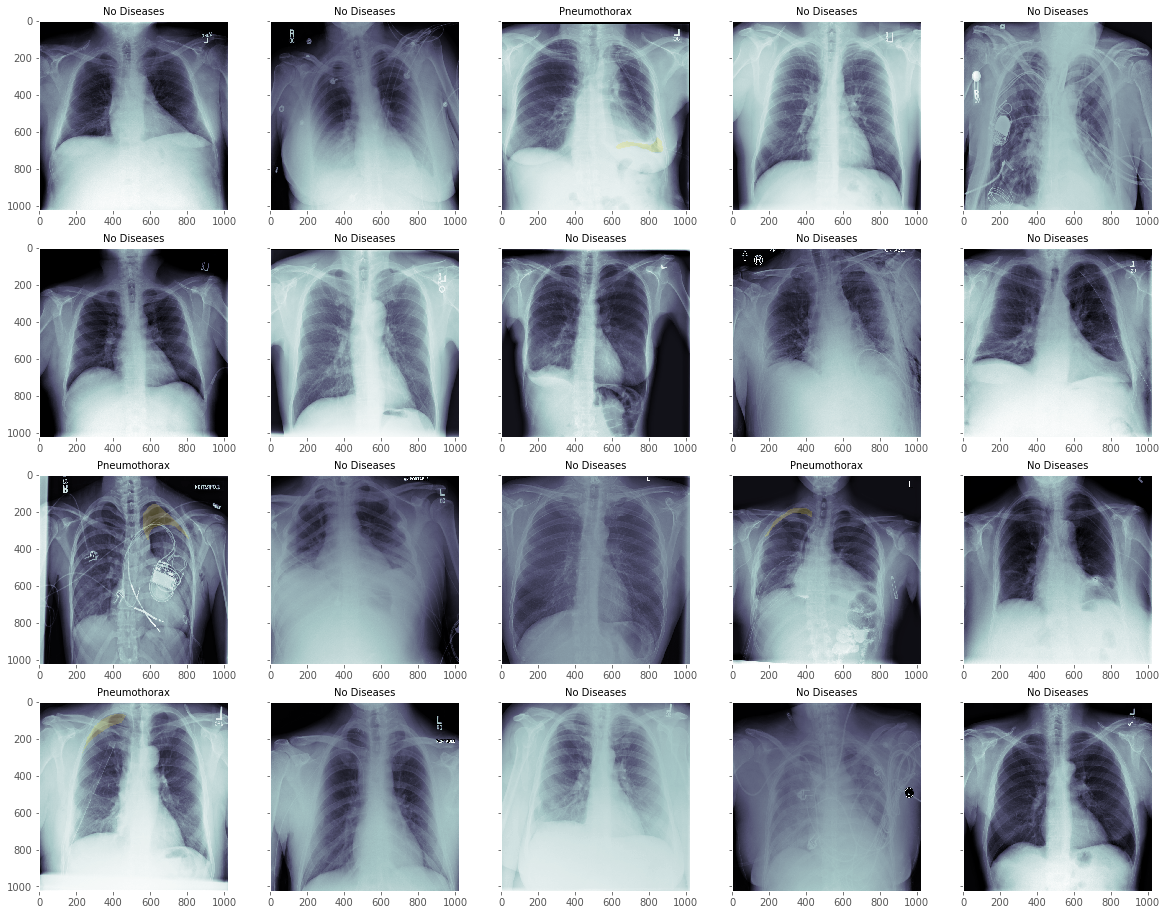

In [21]:
num_img = 5 * 4
fig, ax = plt.subplots(nrows=num_img // 5, ncols=5, sharey=True, figsize=(20, num_img // 5 * 4))
axes = ax.ravel()
for q, fp in enumerate(glob.glob('../dicom-images-train/*/*/*.dcm')[:num_img]):
    dataset = pydicom.dcmread(fp)
    axes[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)
    axes[q].grid(False)
    flag = (tr_rle.loc[:, 'ImageId'] == fp.split('/')[-1][:-4])
    if tr_rle.loc[flag, ' EncodedPixels'].values[0] != ' -1':
        mask = rle2mask(tr_rle.loc[flag, ' EncodedPixels'].values[0], 1024, 1024).T
        axes[q].set_title('Pneumothorax', fontsize=10)
        mask[mask == 0] = np.nan
        axes[q].imshow(mask, alpha = 0.2, vmin = 0, vmax = 1)
    else:
        axes[q].set_title('No Diseases', fontsize=10)

## Zoom In

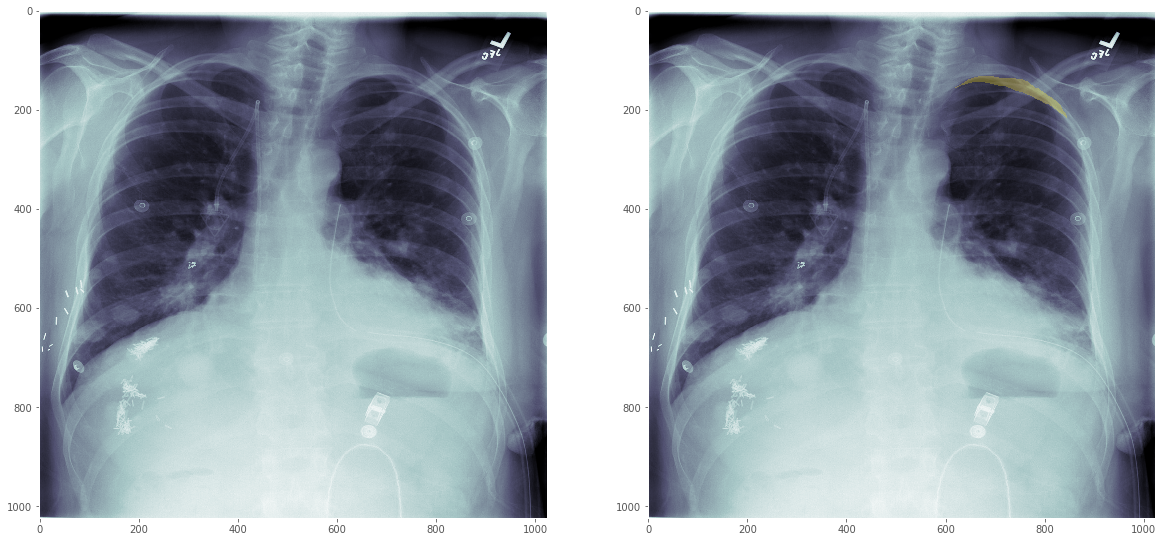

In [22]:
samp_id = tr_rle.loc[tr_rle.IsDisease == True, "ImageId"].sample(1).values[0]
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
axes = ax.ravel()
fp = glob.glob('../dicom-images-train/*/*/{}.dcm'.format(samp_id))[0]
dataset = pydicom.dcmread(fp)
axes[0].imshow(dataset.pixel_array, cmap=plt.cm.bone)
axes[0].grid(False)
axes[1].imshow(dataset.pixel_array, cmap=plt.cm.bone)
axes[1].grid(False)
mask = rle2mask(tr_rle.loc[tr_rle.ImageId == samp_id, ' EncodedPixels'].values[0], 1024, 1024).T
mask[mask == 0] = np.nan
axes[1].imshow(mask, alpha = 0.3, vmin = 0, vmax = 1);

To be honestly, I could NOT identify Pneumothorax from this X-Ray images. I hope our segmentation models can detect these.  
Next I will try [this](https://github.com/JosephPB/XNet).

# EOF